In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import random
from tqdm.notebook import tqdm

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
from evaluator.CodeBLEU.calc_code_bleu import codebleu_fromstr

In [3]:
bleu_metric = evaluate.load("bleu")

In [4]:
result_dir = "../model_outputs"
result_files = [os.path.join(result_dir, file) for file in os.listdir(result_dir) if ".json" in file]
len(result_files)

45

In [5]:
def get_df(result_file):
    with open(result_file, 'r') as f:
        data = json.load(f)
    f.close()
    df = pd.DataFrame(zip(data['preds'], data['references']), columns=['preds', 'gold'])
    return df

In [6]:
def get_token_length(examples):
    model_inputs = tokenizer(examples)
    return len(model_inputs['input_ids'])

In [7]:
from transformers import AutoTokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5p-770m')

# Final Project

In [9]:
def reorder_dict(original_dict):
    inverted_dict = {}
    for inner_key, inner_value in original_dict.items():
        for outer_key, outer_value in inner_value.items():
            if outer_key not in inverted_dict:
                inverted_dict[outer_key] = {}
            inverted_dict[outer_key][inner_key] = outer_value
    return inverted_dict

In [10]:
def get_result_files(result_dir):
    result_dict = dict()
    for path in os.listdir(result_dir):
        key = path
        path = os.path.join(result_dir, path)
        if os.path.isdir(path):
            result_dict[key] = dict()
            if "mtl_out" in path:
                ft_path = os.path.join(path, "test_zeroshot_outputs_step_124000_ft_1600.json")
                if os.path.isfile(ft_path):
                    result_dict[key]['ft'] = ft_path
                zs_path = os.path.join(path, "test_zeroshot_outputs_step_124000.json")
                if os.path.isfile(zs_path):
                    result_dict[key]['zs'] = zs_path
            else:
                ft_path = os.path.join(path, "test_outputs.json")
                if os.path.isfile(ft_path):
                    result_dict[key]['ft'] = ft_path
                zs_path = os.path.join(path, "test_zershot_outputs.json")
                if os.path.isfile(zs_path):
                    result_dict[key]['zs'] = zs_path
    return result_dict

In [11]:
def get_result_df(result_dir):
    result_dict = dict()
    for path in os.listdir(result_dir):
        key = path
        path = os.path.join(result_dir, path)
        if os.path.isdir(path):
            result_dict[key] = dict()
            if "mtl_out" in path:
                ft_path = os.path.join(path, "test_zeroshot_outputs_step_124000_ft_1600.json")
                if os.path.isfile(ft_path):
                    result_dict[key]['ft'] = get_df(ft_path)
                zs_path = os.path.join(path, "test_zeroshot_outputs_step_124000.json")
                if os.path.isfile(zs_path):
                    result_dict[key]['zs'] = get_df(zs_path)
            else:
                ft_path = os.path.join(path, "test_outputs.json")
                if os.path.isfile(ft_path):
                    result_dict[key]['ft'] = get_df(ft_path)
                zs_path = os.path.join(path, "test_zershot_outputs.json")
                if os.path.isfile(zs_path):
                    result_dict[key]['zs'] = get_df(zs_path)
    return result_dict

In [12]:
def preprocess_preds(pred):
    pred = pred.replace('\n', '').replace('\r', '')
    return pred.strip()

In [13]:
def get_code_bleu(preds, golds, lang="python"):
    code_bleu = []
    for pred, gold in tqdm(zip(preds, golds), desc="calculating codeBLEU score"):
        if isinstance(gold, str):
            gold = [gold]
        score = codebleu_fromstr(refs=[gold], hyp=[pred.strip()], lang=lang)
        code_bleu.append(round(score*100, 4))
    return code_bleu

In [14]:
def get_bleu(predictions, references):
    bleu_scores = []
    for index, (pred, gold) in tqdm(enumerate(zip(predictions, references)), desc="calculating BLEU score"):
        # if isinstance(gold, str):
        #     gold = [gold]
        bleu_score = bleu_metric.compute(predictions=[pred], references=[gold])
        bleu_scores.append(round(bleu_score['bleu']*100, 4))
    return bleu_scores

## CodeXGLUE Doc Trans (NL -> NL)

In [15]:
codet5_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/codet5/codet5p_770m/code_x_glue_tt_text_to_text"
Conala_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_conala_cont/code_x_glue_tt_text_to_text"
Conala_CodeSearchNet_dapt_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_full_cont/code_x_glue_tt_text_to_text"
m2rasp_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/mtl_out/mt_mrasp/code_x_glue_tt_text_to_text/"
m2rasp_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/mtl_out/mt_mrasp/code_x_glue_tt_text_to_text/"

In [16]:
result_path_dict = dict()
result_path_dict['codet5+'] = get_result_files(codet5_dir)
result_path_dict['seq2seq_Conala'] = get_result_files(Conala_dir)
result_path_dict['seq2seq_Conala_CodeSearchNet'] = get_result_files(Conala_CodeSearchNet_dapt_dir)
result_path_dict['m2rasp'] = get_result_files(m2rasp_dir)
result_path_dict = reorder_dict(result_path_dict)
pp.pprint(result_path_dict)

{   'da2en': {   'codet5+': {   'ft': '/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/codet5/codet5p_770m/code_x_glue_tt_text_to_text/da2en/test_outputs.json',
                                'zs': '/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/codet5/codet5p_770m/code_x_glue_tt_text_to_text/da2en/test_zershot_outputs.json'},
                 'm2rasp': {},
                 'seq2seq_Conala': {   'zs': '/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_conala_cont/code_x_glue_tt_text_to_text/da2en/test_zershot_outputs.json'},
                 'seq2seq_Conala_CodeSearchNet': {   'zs': '/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_full_cont/code_x_glue_tt_text_to_text/da2en/test_zershot_outputs.json'}},
    'en2da': {   'codet5+': {   'ft': '/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/codet5/codet5

In [17]:
result_df_dict = dict()
result_df_dict['codet5+'] = get_result_df(codet5_dir)
result_df_dict['seq2seq_Conala'] = get_result_df(Conala_dir)
result_df_dict['seq2seq_Conala_CodeSearchNet'] = get_result_df(Conala_CodeSearchNet_dapt_dir)
result_df_dict['m2rasp'] = get_result_df(m2rasp_dir)
result_df_dict = reorder_dict(result_df_dict)

for model_type, values in result_df_dict.items():
    print(f"\n\n{model_type}:")
    for task, results in values.items():
        for result_type, df in results.items():
            print(f"{task}_{result_type}: {df.shape}")



en2no:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


no2en:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


lv2en:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


zh2en:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


en2zh:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


en2da:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


da2en:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


en2lv:
codet5+_ft: (1000, 2)
codet5+_zs: (1000, 2)
seq2seq_Conala_zs: (1000, 2)
seq2seq_Conala_CodeSearchNet_zs: (1000, 2)


## CoNaLa Code Gen and Code Sum (PL -> NL and PL -> NL)

In [15]:
# codet5_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/codet5/codet5p_770m/neulab/conala/"
# Conala_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_conala_cont/neulab/conala/"
# Conala_CodeSearchNet_dapt_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_full_cont/neulab/conala/"
# m2rasp_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/mtl_out/mt_mrasp/neulab/conala/"

codet5_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/codet5/codet5p_770m/neulab/mconala/"
Conala_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_conala_cont/neulab/mconala/"
Conala_CodeSearchNet_dapt_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/seq2seq_unified_full_cont/neulab/mconala/"
m2rasp_dir = "/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/mtl_out/mt_mrasp/neulab/mconala/"

In [16]:
result_path_dict = dict()
result_path_dict['codet5+'] = get_result_files(codet5_dir)
result_path_dict['seq2seq_Conala'] = get_result_files(Conala_dir)
result_path_dict['seq2seq_Conala_CodeSearchNet'] = get_result_files(Conala_CodeSearchNet_dapt_dir)
result_path_dict['m2rasp'] = get_result_files(m2rasp_dir)
result_path_dict = reorder_dict(result_path_dict)
pp.pprint(result_path_dict)

FileNotFoundError: [Errno 2] No such file or directory: '/data/tir/projects/tir4/users/ymathur/mnlp/MultiLingProject/hf_out_copy/hf_out/codet5/codet5p_770m/neulab/mconala/'

In [14]:
result_df_dict = dict()
result_df_dict['codet5+'] = get_result_df(codet5_dir)
result_df_dict['seq2seq_Conala'] = get_result_df(Conala_dir)
result_df_dict['seq2seq_Conala_CodeSearchNet'] = get_result_df(Conala_CodeSearchNet_dapt_dir)
result_df_dict['m2rasp'] = get_result_df(m2rasp_dir)
result_df_dict = reorder_dict(result_df_dict)

for model_type, values in result_df_dict.items():
    print(f"\n\n{model_type}:")
    for task, results in values.items():
        for result_type, df in results.items():
            print(f"{task}_{result_type}: {df.shape}")



en2py:
codet5+_ft: (500, 2)
codet5+_zs: (500, 2)
seq2seq_Conala_ft: (500, 2)
seq2seq_Conala_zs: (500, 2)
seq2seq_Conala_CodeSearchNet_ft: (500, 2)
seq2seq_Conala_CodeSearchNet_zs: (500, 2)
m2rasp_ft: (500, 2)
m2rasp_zs: (500, 2)


py2en:
codet5+_ft: (500, 2)
codet5+_zs: (500, 2)
seq2seq_Conala_ft: (500, 2)
seq2seq_Conala_zs: (500, 2)
seq2seq_Conala_CodeSearchNet_ft: (500, 2)
seq2seq_Conala_CodeSearchNet_zs: (500, 2)
m2rasp_ft: (500, 2)
m2rasp_zs: (500, 2)


In [18]:
for task, values in result_df_dict.items():
    
    print(f"\n\n{task}:")
    for model_type, results in values.items():
        
        for result_type, df in results.items():
            
            print(f"{model_type}_{result_type}")
            
            df = result_df_dict[task][model_type][result_type]
            df['preds'] = df['preds'].apply(lambda x: preprocess_preds(x))
            df = df[df['preds']!= ""].reset_index(drop=True)
            df['length_gold'] = df['gold'].apply(lambda x: int(get_token_length(x[0])))
            df['length_preds'] = df['preds'].apply(lambda x: int(get_token_length(x[0])))
            df = df[df['length_gold'] > 0].reset_index(drop=True)
            df = df[df['length_preds'] > 0].reset_index(drop=True)
            
            df['bleu'] = get_bleu(df['preds'].tolist(), df['gold'].tolist())

            if task == "en2py":
                df['code_bleu'] = get_code_bleu(df['preds'].tolist(), df['gold'].tolist(), lang="python")
                            
            result_df_dict[task][model_type][result_type] = df



en2py:
codet5+_ft


calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.6, dataflow_match: 0
ngram match: 0.029950417327249696, weighted ngram match: 0.027301208627090675, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 1.0, dataflow_match: 0
ngram match: 0.1810756925110502, weighted ngram match: 0.2044800736021839, syntax_match: 0.5, dataflow_match: 0.8
ngram match: 0.3502613068493141, weighted ngram match: 0.3738756341722267, syntax_match: 0.38461538461538464, dataflow_match: 0.3
ngram match: 0, weighted ngram match: 0, syntax_match: 0.2857142857142857, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.07142857142857142, dataflow_match: 1.0
ngram match: 0, weighted ng

calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0.0013867536805178273, weighted ngram match: 0.048549177170732344, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.16666666666666666, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.09090

calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0.029950417327249696, weighted ngram match: 0.027301208627090675, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.6, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.2857142857142857, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.07142857142857142, dataflow_match: 0.5
ngram match: 0, weighted ngram match: 0, syntax_match: 0.16666666666666666, dataflow_match: 0
ngram match: 0, w

calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 1.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0.06985342056580097, weighted ngram match: 0.09036020036098448, syntax_match: 0.0, dataflow_match: 0.5
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.6, dataflow_match: 0
ngram match: 0.013120543279239774, weighted ngram match: 0.011441973823299794, syntax_match: 0.0, dataflow_match: 0.4
ngram match: 0.013120543279239774, weighted ngram match: 0.011441973823299794, syntax_match: 0.0, dataflow_match: 0.4
ngram match: 0, weighted ngram match: 0, syntax_match: 0.14285714285714285, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.07142857142857142, dataflow_match: 0.5
ngram match: 0, weighted ngram match

calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 1.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0.20556680845025987, weighted ngram match: 0.215748619491674, syntax_match: 1.0, dataflow_match: 1.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.6, dataflow_match: 0
ngram match: 0.017267606045625942, weighted ngram match: 0.020837668330032085, syntax_match: 0.35714285714285715, dataflow_match: 0.5
ngram match: 0.017267606045625942, weighted ngram match: 0.020837668330032085, syntax_match: 0.23076923076923078, dataflow_match: 0.2
ngram match: 0, weighted ngram match: 0, syntax_match: 0.2857142857142857, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.21428571428571427, dataflow_match: 0.0
ngram m

calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 1.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0.17286039232097053, weighted ngram match: 0.215748619491674, syntax_match: 0.7142857142857143, dataflow_match: 1.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 1.0, dataflow_match: 0
ngram match: 0.007842752028330948, weighted ngram match: 0.01360687668034301, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0.0065949420663472934, weighted ngram match: 0.011441973823299794, syntax_match: 0.0, dataflow_match: 0.1
ngram match: 0, weighted ngram match: 0, syntax_match: 0.2857142857142857, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.4, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.21428571428571427, dataflow_match: 0.0
ngram match: 0, weighted

calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.6, dataflow_match: 0
ngram match: 0.029950417327249696, weighted ngram match: 0.027301208627090675, syntax_match: 0.0, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.5, dataflow_match: 0
ngram match: 0.2124149425282805, weighted ngram match: 0.22289050740788352, syntax_match: 0.42857142857142855, dataflow_match: 0.5
ngram match: 0.4071631883019393, weighted ngram match: 0.4012258424906397, syntax_match: 0.7692307692307693, dataflow_match: 0.2
ngram match: 0, weighted ngram match: 0, syntax_match: 0.2857142857142857, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.5, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.07142857142857142, dataflow_match: 0.5
ngram match

calculating BLEU score: 0it [00:00, ?it/s]

calculating codeBLEU score: 0it [00:00, ?it/s]

ngram match: 0, weighted ngram match: 0, syntax_match: 0.5555555555555556, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0.75
ngram match: 0, weighted ngram match: 0, syntax_match: 0.3333333333333333, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.1, dataflow_match: 0
ngram match: 0.41653323821535565, weighted ngram match: 0.4191013657888413, syntax_match: 0.35714285714285715, dataflow_match: 0.4
ngram match: 0.1895201826718251, weighted ngram match: 0.19479184512554418, syntax_match: 0.38461538461538464, dataflow_match: 0.2
ngram match: 0, weighted ngram match: 0, syntax_match: 0.14285714285714285, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.0, dataflow_match: 0
ngram match: 0, weighted ngram match: 0, syntax_match: 0.07142857142857142, dataflow_match: 0.0
ngram match: 0, weighted ngram match: 0, synt

calculating BLEU score: 0it [00:00, ?it/s]

codet5+_zs


calculating BLEU score: 0it [00:00, ?it/s]

seq2seq_Conala_ft


calculating BLEU score: 0it [00:00, ?it/s]

seq2seq_Conala_zs


calculating BLEU score: 0it [00:00, ?it/s]

seq2seq_Conala_CodeSearchNet_ft


calculating BLEU score: 0it [00:00, ?it/s]

seq2seq_Conala_CodeSearchNet_zs


calculating BLEU score: 0it [00:00, ?it/s]

m2rasp_ft


calculating BLEU score: 0it [00:00, ?it/s]

m2rasp_zs


calculating BLEU score: 0it [00:00, ?it/s]

In [19]:
for task, values in result_df_dict.items():
    
    print(f"\n\n{task}:")
    for model_type, results in values.items():
        
        for result_type, df in results.items():
            df = result_df_dict[task][model_type][result_type]
            if task == "en2py":
                print(f"\n{model_type}_{result_type}:\tbleu:{round(df['bleu'].mean(), 2)}\tcode_bleu: {round(df['code_bleu'].mean(), 2)}")
            else:
                print(f"\n{model_type}_{result_type}:\tbleu:{round(df['bleu'].mean(), 2)}")



en2py:

codet5+_ft:	bleu:8.11	code_bleu: 11.32

codet5+_zs:	bleu:0.1	code_bleu: 6.96

seq2seq_Conala_ft:	bleu:9.79	code_bleu: 11.42

seq2seq_Conala_zs:	bleu:7.78	code_bleu: 10.45

seq2seq_Conala_CodeSearchNet_ft:	bleu:10.5	code_bleu: 11.66

seq2seq_Conala_CodeSearchNet_zs:	bleu:9.02	code_bleu: 11.04

m2rasp_ft:	bleu:9.77	code_bleu: 12.23

m2rasp_zs:	bleu:6.79	code_bleu: 9.97


py2en:

codet5+_ft:	bleu:1.65

codet5+_zs:	bleu:0.0

seq2seq_Conala_ft:	bleu:1.01

seq2seq_Conala_zs:	bleu:0.1

seq2seq_Conala_CodeSearchNet_ft:	bleu:1.36

seq2seq_Conala_CodeSearchNet_zs:	bleu:0.09

m2rasp_ft:	bleu:1.39

m2rasp_zs:	bleu:0.0




en2py:


py2en:


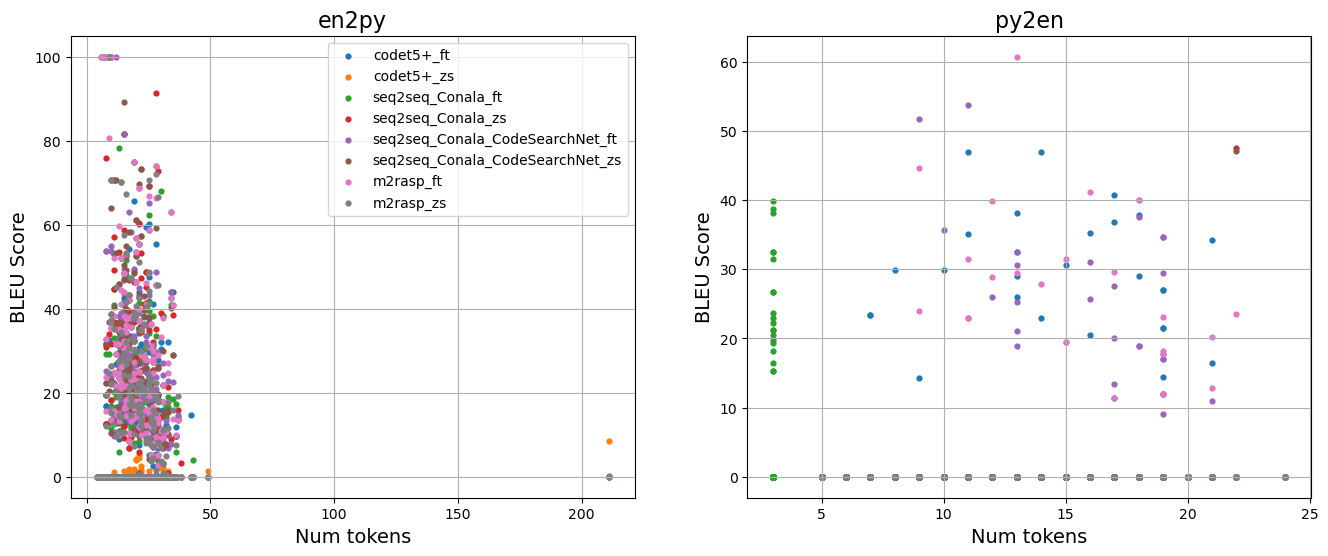

In [27]:
fig, s1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1, ax2 = s1
cnt = 0

for task, values in result_df_dict.items():
    
    print(f"\n\n{task}:")
    for model_type, results in values.items():
        
        for result_type, df in results.items():
            df = result_df_dict[task][model_type][result_type]
            if task == "en2py":
                ax1.scatter(df['length_gold'], df['bleu'], marker='o', s=12, label=f"{model_type}_{result_type}")
                # if cnt >= 4:
                ax1.set_xlabel('Num tokens', fontsize=14)
                # if cnt in [0, 4]:
                ax1.set_ylabel(f'BLEU Score', fontsize=14)
                # axis.legend(loc='lower right', fontsize=18)
                ax1.set_title(task, fontsize=16)
                ax1.grid(True)
                ax1.legend()
                cnt += 1
            else:
                ax2.scatter(df['length_gold'], df['bleu'], marker='o', s=12, label=f"{model_type}_{result_type}")
                # if cnt >= 4:
                ax2.set_xlabel('Num tokens', fontsize=14)
                # if cnt in [0, 4]:
                ax2.set_ylabel(f'BLEU Score', fontsize=14)
                # axis.legend(loc='lower right', fontsize=18)
                ax2.set_title(task, fontsize=16)
                ax2.grid(True)
                # ax2.legend()
                cnt += 1
                
plt.savefig("conala_bleu.pdf", dpi=600)
plt.show()



en2py:


py2en:


KeyError: 'code_bleu'

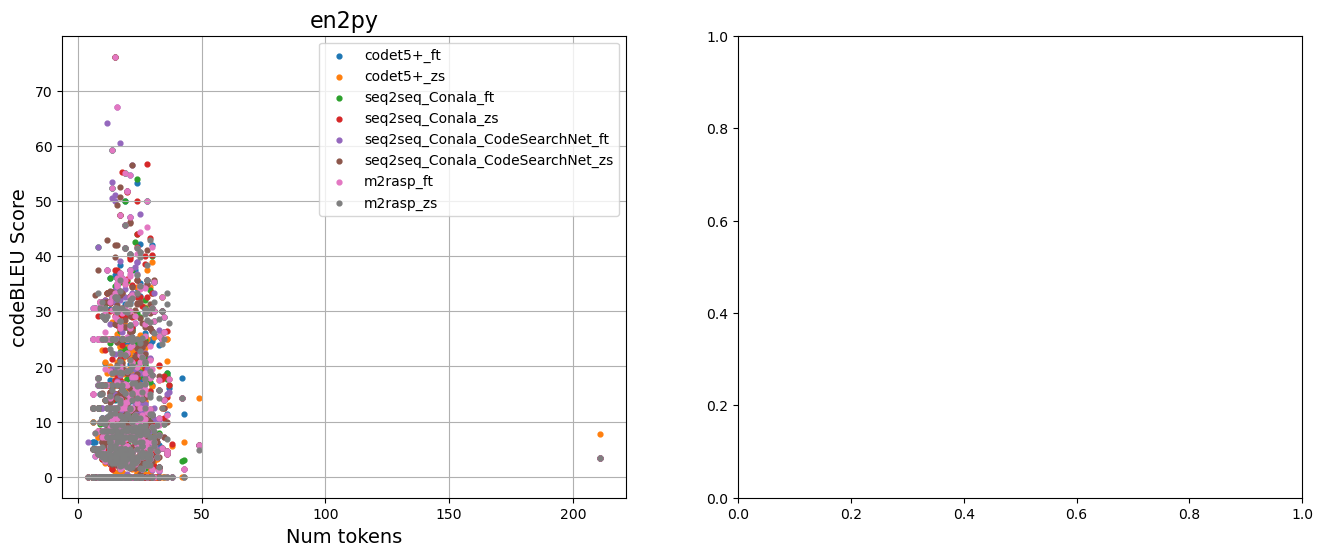

In [28]:
fig, s1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1, ax2 = s1
cnt = 0

for task, values in result_df_dict.items():
    
    print(f"\n\n{task}:")
    for model_type, results in values.items():
        
        for result_type, df in results.items():
            df = result_df_dict[task][model_type][result_type]
            if task == "en2py":
                ax1.scatter(df['length_gold'], df['code_bleu'], marker='o', s=12, label=f"{model_type}_{result_type}")
                # if cnt >= 4:
                ax1.set_xlabel('Num tokens', fontsize=14)
                # if cnt in [0, 4]:
                ax1.set_ylabel(f'codeBLEU Score', fontsize=14)
                # axis.legend(loc='lower right', fontsize=18)
                ax1.set_title(task, fontsize=16)
                ax1.grid(True)
                ax1.legend()
                cnt += 1
            else:
                ax2.scatter(df['length_gold'], df['code_bleu'], marker='o', s=12, label=f"{model_type}_{result_type}")
                # if cnt >= 4:
                ax2.set_xlabel('Num tokens', fontsize=14)
                # if cnt in [0, 4]:
                ax2.set_ylabel(f'codeBLEU Score', fontsize=14)
                # axis.legend(loc='lower right', fontsize=18)
                ax2.set_title(task, fontsize=16)
                ax2.grid(True)
                # ax2.legend()
                cnt += 1
                
# plt.savefig("conala_code_bleu.pdf", dpi=600)
plt.show()

## CodeSearchNet Code Gen and Code Sum (PL -> NL and NL -> PL)

In [ ]:
codet5_dir = ""
conala_dapt_dir = ""
full_dapt_dir = ""
mt_mrasp_dir = ""

# Mid-Term Project

## CodexGLEU Code Trans

In [10]:
code_tans_files = [file for file in result_files if "codexglue_c2c_code_trans" in file and "test_outputs" in file]
len(code_tans_files), code_tans_files

(2,
 ['../model_outputs/hf_out-codet5-codet5p_770m-codexglue_c2c_code_trans-cs2java-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-codexglue_c2c_code_trans-java2cs-test_outputs.json'])

In [11]:
df_dict = {code_tans_file.split('codexglue_c2c_code_trans-')[-1].split('-test_outputs.json')[0]: get_df(code_tans_file) for code_tans_file in code_tans_files}
for key, val in df_dict.items():
    df = df_dict[key]
    df['bleu'] = get_bleu(df['preds'].tolist(), df['gold'].tolist())
    df['length'] = df['gold'].apply(lambda x: get_token_length(x[0]))
    df_dict[key] = df
    print(key, val.shape)

cs2java (1000, 4)
java2cs (1000, 4)


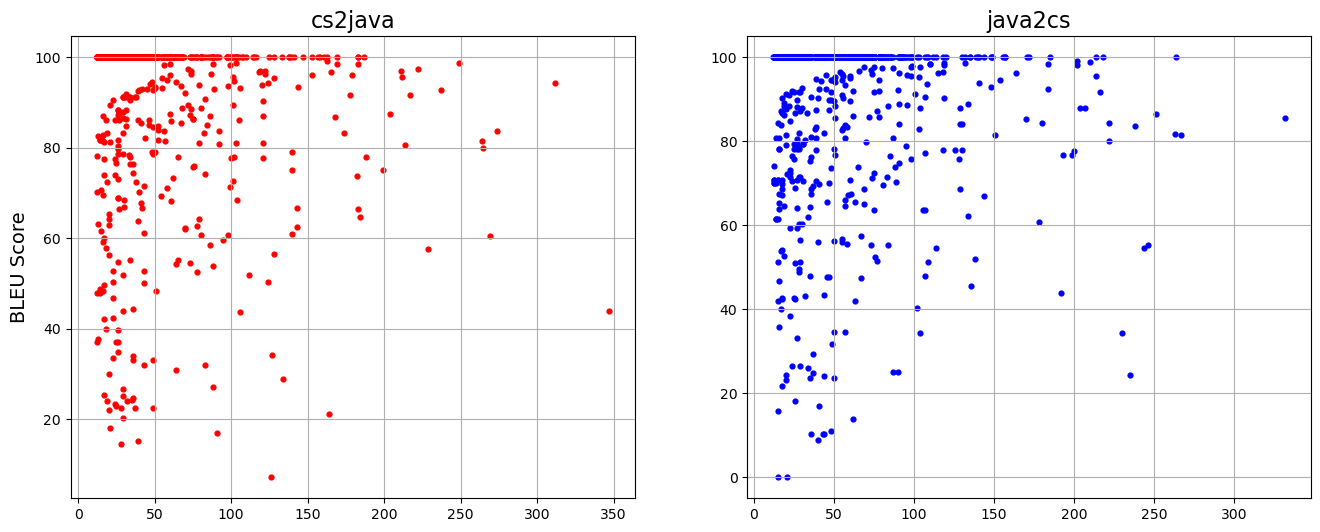

In [11]:
fig, s1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1, ax2 = s1
axes = [ax1, ax2]

cnt = 0
color = ['red', 'blue']
for axis, (lang, df) in zip(axes, df_dict.items()):
    axis.scatter(df['length'], df['bleu'], marker='o', color=color[cnt], s=12)
    if cnt >= 4:
        axis.set_xlabel('Num tokens', fontsize=14)
    if cnt in [0, 4]:
        axis.set_ylabel(f'BLEU Score', fontsize=14)
    # axis.legend(loc='lower right', fontsize=18)
    axis.set_title(lang, fontsize=16)
    axis.grid(True)
    cnt += 1

# plt.savefig("plots/codegluex_code_trans_token_bleu_pareto.pdf", dpi=600)

plt.show()

## CodexGLEU Doc Trans

In [12]:
doc_tans_files = [file for file in result_files if "code_x_glue_tt_text" in file and "test_outputs" in file]
len(doc_tans_files), doc_tans_files

(8,
 ['../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-zh2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2da-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2no-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-no2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-lv2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2zh-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-da2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_tt_text_to_text-en2lv-test_outputs.json'])

In [13]:
df_dict = {doc_tans_file.split('code_x_glue_tt_text_to_text-')[-1].split('-test_outputs.json')[0]: get_df(doc_tans_file) for doc_tans_file in doc_tans_files}
for key, val in df_dict.items():
    df = df_dict[key]
    df['bleu'] = get_bleu(df['preds'].tolist(), df['gold'].tolist())
    df['length'] = df['gold'].apply(lambda x: get_token_length(x[0]))
    df_dict[key] = df
    print(key, val.shape)

zh2en (1000, 4)
en2da (1000, 4)
en2no (1000, 4)
no2en (1000, 4)
lv2en (1000, 4)


Token indices sequence length is longer than the specified maximum sequence length for this model (656 > 512). Running this sequence through the model will result in indexing errors


en2zh (1000, 4)
da2en (1000, 4)
en2lv (1000, 4)


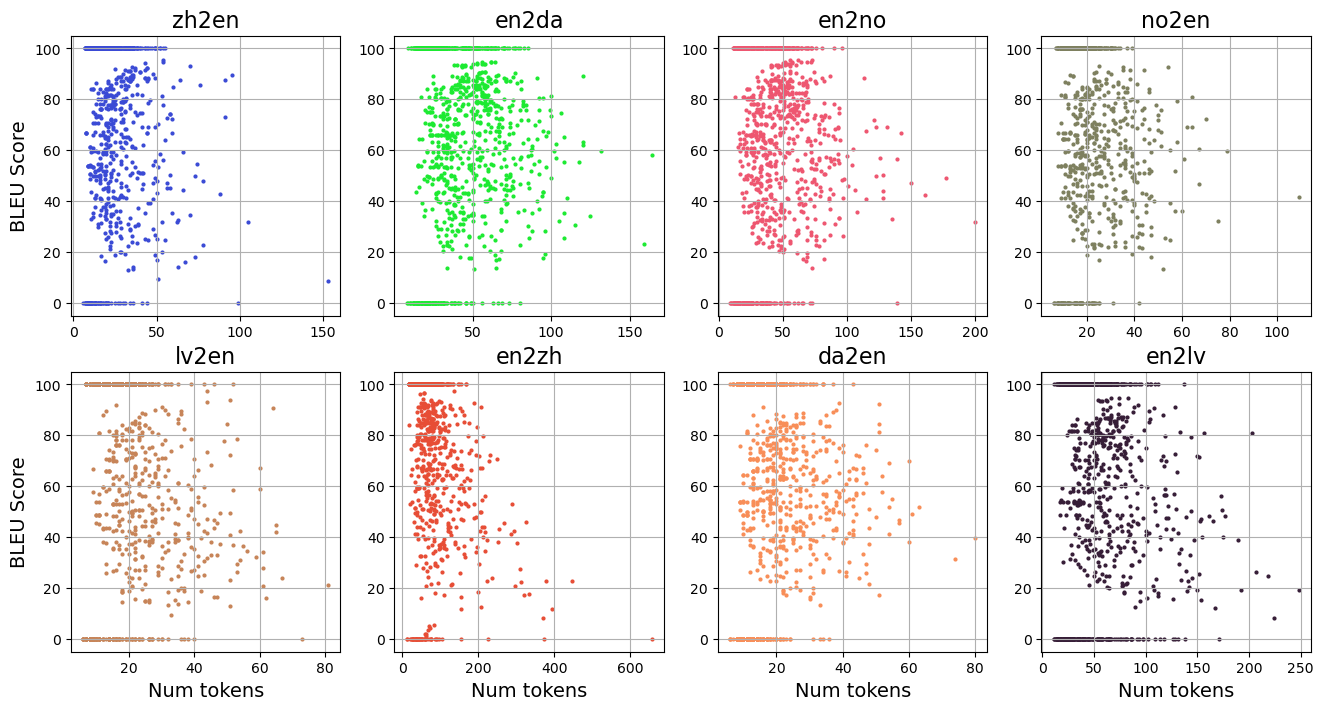

In [15]:
fig, (s1, s2) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

ax1, ax2, ax3, ax4 = s1
ax5, ax6, ax7, ax8 = s2

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

hexadecimal_alphabets = '0123456789ABCDEF'
number_of_colors = len(df_dict)
color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(number_of_colors)]

cnt = 0
for axis, (lang, df) in zip(axes, df_dict.items()):
    axis.scatter(df['length'], df['bleu'], marker='o', color=color[cnt], s=4)
    if cnt >= 4:
        axis.set_xlabel('Num tokens', fontsize=14)
    if cnt in [0, 4]:
        axis.set_ylabel(f'BLEU Score', fontsize=14)
    # axis.legend(loc='lower right', fontsize=18)
    axis.set_title(lang, fontsize=16)
    axis.grid(True)
    cnt += 1

plt.savefig("plots/codegluex_doc_trans_token_bleu_pareto.pdf", dpi=600)

plt.show()

## NL to PL and PL to NL

In [16]:
trans_files = [file for file in result_files if "test_outputs" in file and "code_x_glue_ct_code_to_text" in file and "en2" not in file]
len(trans_files), trans_files

(6,
 ['../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-javascript2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-go2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-ruby2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-php2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-java2en-test_outputs.json',
  '../model_outputs/hf_out-codet5-codet5p_770m-code_x_glue_ct_code_to_text-python2en-test_outputs.json'])

In [17]:
df_dict = {trans_file.split('code_x_glue_ct_code_to_text-')[-1].split('-test_outputs.json')[0]: get_df(trans_file) for trans_file in trans_files}
for key, val in df_dict.items():
    df = df_dict[key]
    df['bleu'] = get_bleu(df['preds'].tolist(), df['gold'].tolist())
    df['length'] = df['gold'].apply(lambda x: get_token_length(x[0]))
    df_dict[key] = df
    print(key, val.shape)

javascript2en (777, 4)
go2en (1465, 4)
ruby2en (280, 4)
php2en (2596, 4)
java2en (1037, 4)
python2en (2783, 4)


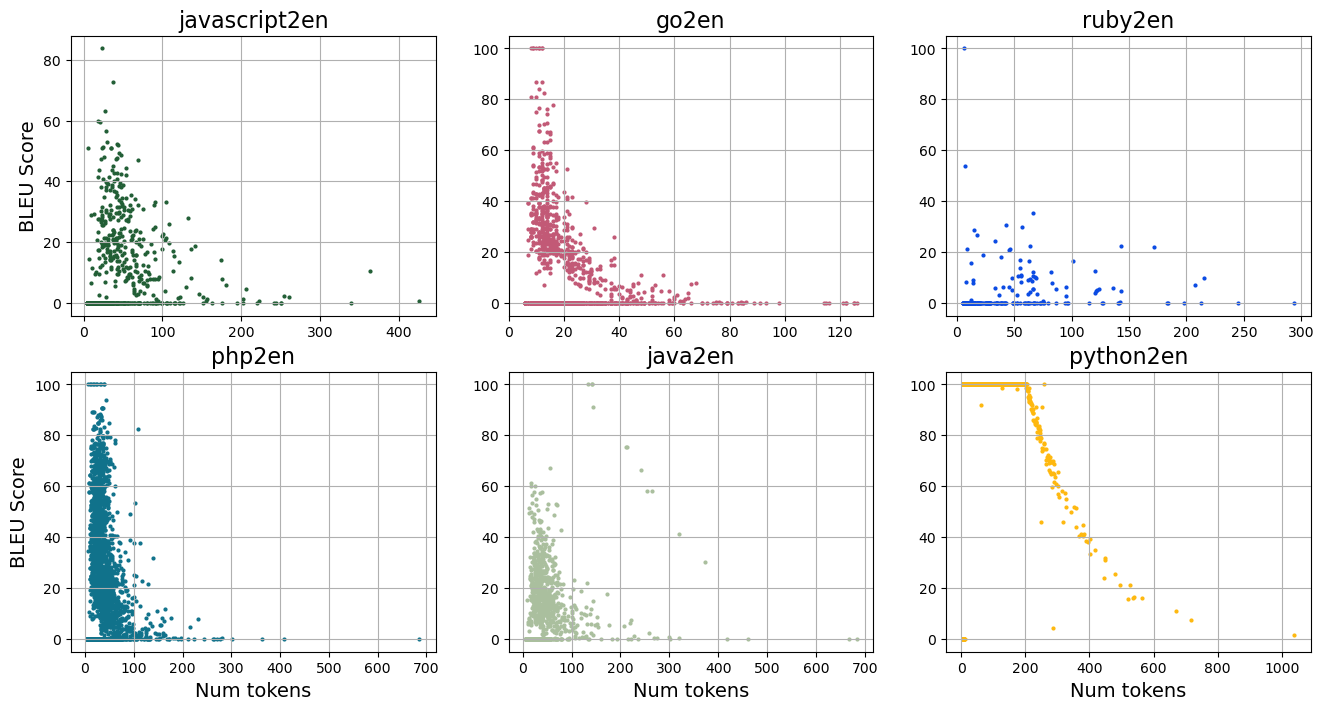

In [28]:
fig, (s1, s2) = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

ax1, ax2, ax3  = s1
ax4, ax5, ax6 = s2

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

hexadecimal_alphabets = '0123456789ABCDEF'
number_of_colors = len(df_dict)
color = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in
range(6)]) for i in range(number_of_colors)]

cnt = 0
for axis, (lang, df) in zip(axes, df_dict.items()):
    axis.scatter(df['length'], df['bleu'], marker='o', color=color[cnt], s=4)
    if cnt >= 3:
        axis.set_xlabel('Num tokens', fontsize=14)
    if cnt in [0, 3]:
        axis.set_ylabel(f'BLEU Score', fontsize=14)
    # axis.legend(loc='lower right', fontsize=18)
    axis.set_title(lang, fontsize=16)
    axis.grid(True)
    cnt += 1

plt.savefig("plots/codegluex_pl_nl_token_bleu_pareto.pdf", dpi=600)

plt.show()